In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
print('load libraries')
import datetime
import xarray as xr
import numpy as np
import dask
from tqdm import tqdm
import pandas as pd
import xwmb
import xwmt
import xgcm
import warnings
warnings.filterwarnings('ignore')
import cftime
xwmb.__version__, xwmt.__version__, xgcm.__version__

load libraries


('0.1.0', '0.1.1', '0.8.2.dev15+g7492277')

In [3]:
print("loading ds, snap, static...")
hfdrake_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/data_daily/"
ds = xr.open_mfdataset(f"{hfdrake_path}/*.ocean_daily.*.nc", chunks={"time":1})
ds = ds.isel(yh=slice(1, None), yq=slice(None, -1), xh=slice(1,None), xq=slice(None, -1)) # realign cell center/corner coordinates

snap = xr.open_mfdataset(f"{hfdrake_path}/*.ocean_daily_snap*.nc", chunks={"time":1})
# Rename snapshot time coordinates to time_bounds so they can later be merged with ds
snap = snap.rename({
    **{'time': 'time_bounds'},
    **{v: f"{v}_bounds" for v in snap.data_vars}
    })

static = xr.open_dataset("/pub/hfdrake/datasets/CM4_MHW_blobs/data/WMT_monthly/ocean_month_rho2.static.nc")
print("...loaded ds, snap, static")

print("loading labels,df...")
mt_path = "/pub/mariant3/WarmWaterMasses/data/"
labels = xr.open_dataset(f"{mt_path}ocetracv6/ocetrac-v6-processed/ocetrac-v6-blobs-tos-t1-r1-msq0-01860315-01891214-manso.nc").blobs.rename('event_mask')

#Get rid of one_day_ids
ids = np.unique(labels)
ids = np.array([id for id in ids if ~np.isnan(id)])
print(len(ids))
one_day_ids = [mhw for mhw in ids if len(labels.where(labels == mhw, drop=True).time) == 1]
print(len(one_day_ids))
ids = np.array([id for id in ids if id not in one_day_ids])
print(len(ids))

loading ds, snap, static...
...loaded ds, snap, static
loading labels,df...


In [97]:
mhw = ids[0] # ids[2] is a good big event test case
mhw

210.0

In [442]:
print(f'...Working on event {mhw}')
mhw_df = df.loc[df.id==mhw]

print('----------------- starting cumulative mask part -----------------')

# Create centered 3-day rolling cumulative mask
event_mask = (labels == mhw).rolling({"time":3}, center=True).max("time").fillna(0.).astype("float64")

# Zoom in on time period of event (+ 1 day before and 1 day after)
event_times = event_mask.time[event_mask.any(["xh", "yh"]).compute()]
event_mask = event_mask.sel(time=slice(
    event_times[ 0] + datetime.timedelta(days = -1),
    event_times[-1] + datetime.timedelta(days =  1),
))

# Merge budget diagnostics with the event mask
ds_event = xr.merge([ds, event_mask], join='inner')

# Get snapshots that bound the event
snap_event = snap.sel(
    time_bounds=slice(
        ds_event.time[0].values + datetime.timedelta(days = -1),
        ds_event.time[-1].values + datetime.timedelta(days = 1)
    )
)

# Merge budget diagnostics, snapshots, and static grid
ds_event = xr.merge([ds_event, snap_event, static], join='inner')

# Zoom in on region of the actual event
xh_event = ds_event.xh[ds_event.event_mask.any(["time", "yh"])]
yh_event = ds_event.yh[ds_event.event_mask.any(["time", "xh"])]
ds_event = ds_event.sel(xh=xh_event, yh=yh_event)

# Realign tracer center/corner coordinates because inner "join" only shrinks the ("xh", "yh") dimensions!
xq_inner = ds_event.xq.sel(xq=slice(ds_event.xh[0], ds_event.xh[-1]))
xq_islice = (np.abs(ds_event.xq - xq_inner[0]).argmin().values - 1, np.abs(ds_event.xq - xq_inner[-1]).argmin().values + 2)

yq_inner = ds_event.yq.sel(yq=slice(ds_event.yh[0], ds_event.yh[-1]))
yq_islice = (np.abs(ds_event.yq - yq_inner[0]).argmin().values - 1, np.abs(ds_event.yq - yq_inner[-1]).argmin().values + 2)

ds_event = ds_event.isel(xq=slice(*xq_islice), yq=slice(*yq_islice))

...Working on event 210.0
----------------- starting cumulative mask part -----------------


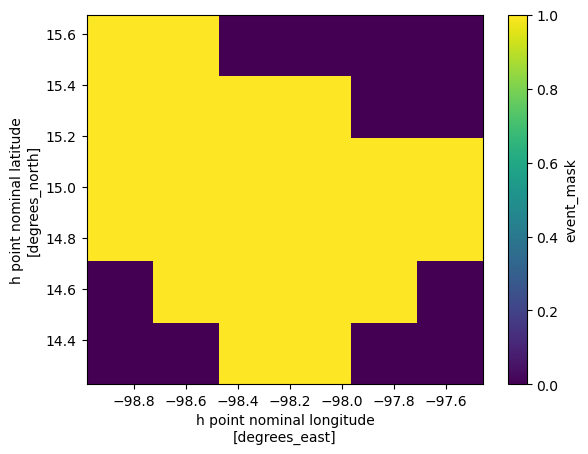

In [443]:
ds_event.event_mask.any("time").plot()

In [444]:
print('----------------- Adding core coordinates of static to ds_event -----------------')

def add_estimated_layer_interfaces(ds):
    return ds.assign_coords({"zi": xr.DataArray(
        np.concatenate([[0], 0.5*(ds.zl.values[1:]+ds.zl.values[0:-1]), [6000]]),
        dims=('zi',)
    )})
ds_event = add_estimated_layer_interfaces(ds_event)

ds_event = ds_event.assign_coords({
    "areacello": xr.DataArray(ds_event["areacello"].values, dims=('yh', 'xh',)), # Required for area-integration
    "lon": xr.DataArray(ds_event["geolon"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "lat": xr.DataArray(ds_event["geolat"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "xq": xr.DataArray(ds_event["xq"].values, dims=('xq',)),
    "yq": xr.DataArray(ds_event["yq"].values, dims=('yq',)),
    "deptho": xr.DataArray(ds_event["deptho"].values, dims=('yh', 'xh',)),
    "geolon": xr.DataArray(ds_event["geolon"].values, dims=('yh', 'xh',)),
    "geolat": xr.DataArray(ds_event["geolat"].values, dims=('yh', 'xh',)),
    "geolon_c": xr.DataArray(ds_event["geolon_c"].values, dims=('yq', 'xq',)),
    "geolat_c": xr.DataArray(ds_event["geolat_c"].values, dims=('yq', 'xq',)),
})
coords = {
'X': {'center': 'xh', 'outer': 'xq'},
'Y': {'center': 'yh', 'outer': 'yq'},
'Z': {'center': 'zl', 'outer': 'zi'}
}
metrics = {
    ('X','Y'): "areacello", # Required for area-integration
}

ds_event['tos'] = ds_event['thetao'].isel(zl=0)

----------------- Adding core coordinates of static to ds_event -----------------


In [445]:
import numpy as np
import regionate
import matplotlib.pyplot as plt
import warnings

def _calc_temperature_wmt(ds_event):
    lam = "heat"
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
            
        grid = xgcm.Grid(ds_event.copy(), coords=coords, metrics=metrics, boundary={'X':'extend', 'Y':'extend', 'Z':'extend'}, autoparse_metadata=False)
        wm = xwmt.WaterMass(grid)
        
        import xbudget
        budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly").copy()
        del budgets_dict['salt']['lhs']
        del budgets_dict['salt']['rhs']
        
        xbudget.collect_budgets(grid, budgets_dict)
    
        wmb = xwmb.WaterMassBudget(
            grid,
            budgets_dict,
            ds_event.event_mask.squeeze() if ds_event.event_mask.squeeze().any() else None
        )
        wmb.mass_budget(lam, greater_than=True, default_bins=True)

    return wmb.wmt

def sel_times(ds, t):
    return ds.sel(
        time = t.expand_dims("time"),
        time_bounds = slice(
            t + datetime.timedelta(days = -1),
            t + datetime.timedelta(days = 1)
        )
    )

In [446]:
%%time
wmt = xr.concat([
    _calc_temperature_wmt(sel_times(ds_event, t)).drop_dims(["time_bounds"])
    for t in ds_event.time
], dim="time")
wmt.load()

CPU times: user 8.11 s, sys: 651 ms, total: 8.76 s
Wall time: 11.9 s


<xarray.Dataset>
Dimensions:                                    (time: 9, thetao_l_target: 440,
                                                thetao_i_target: 441, xh: 6,
                                                yh: 6)
Coordinates:
  * time                                       (time) object 0186-04-05 12:00...
  * thetao_l_target                            (thetao_l_target) float64 -4.0...
  * thetao_i_target                            (thetao_i_target) float64 -4.0...
  * xh                                         (xh) float64 -98.86 ... -97.58
  * yh                                         (yh) float64 14.35 ... 15.56
    geolat                                     (yh, xh) float32 14.35 ... 15.56
    geolon                                     (yh, xh) float32 -98.88 ... -9...
    areacello                                  (yh, xh) float32 7.271e+08 ......
    deptho                                     (yh, xh) float32 3.432e+03 ......
    lon                                        (yh, xh) float32 -98.88 ... -9...
    lat                                        (yh, xh) float32 14.35 ... 15.56
Data variables: (12/20)
    Eulerian_tendency                          (time, thetao_l_target) float64 ...
    diffusion                                  (time, thetao_l_target) float64 ...
    advection                                  (time, thetao_l_target) float64 ...
    surface_ocean_flux_advective_negative_lhs  (time, thetao_l_target) float64 ...
    frazil_ice                                 (time, thetao_l_target) float64 ...
    surface_ocean_flux_advective_negative_rhs  (time, thetao_l_target) float64 ...
    ...                                         ...
    mass_tendency                              (time, thetao_l_target) float64 ...
    dt                                         (time) float64 8.64e+04 ... 8....
    realized_transformation                    (time, thetao_l_target) float64 ...
    spurious_numerical_mixing                  (time, thetao_l_target) float64 ...
    advection_plus_BC                          (time, thetao_l_target) float64 ...
    diabatic_advection                         (time, thetao_l_target) float64 ...

In [447]:
%%time
ds_event_old_cumulative_mask = ds_event.copy()
ds_event_old_cumulative_mask["event_mask"] = ds_event_old_cumulative_mask.event_mask.any("time")
wmt_old_cumulative_mask = _calc_temperature_wmt(ds_event_old_cumulative_mask).drop_dims(["time_bounds"])
wmt_old_cumulative_mask.load()

CPU times: user 3.54 s, sys: 619 ms, total: 4.15 s
Wall time: 3.8 s


<xarray.Dataset>
Dimensions:                                    (time: 9, thetao_l_target: 440,
                                                thetao_i_target: 441, xh: 6,
                                                yh: 6)
Coordinates:
  * time                                       (time) object 0186-04-05 12:00...
  * thetao_l_target                            (thetao_l_target) float64 -4.0...
  * thetao_i_target                            (thetao_i_target) float64 -4.0...
  * xh                                         (xh) float64 -98.86 ... -97.58
  * yh                                         (yh) float64 14.35 ... 15.56
    geolat                                     (yh, xh) float32 14.35 ... 15.56
    geolon                                     (yh, xh) float32 -98.88 ... -9...
    areacello                                  (yh, xh) float32 7.271e+08 ......
    deptho                                     (yh, xh) float32 3.432e+03 ......
    lon                                        (yh, xh) float32 -98.88 ... -9...
    lat                                        (yh, xh) float32 14.35 ... 15.56
Data variables: (12/20)
    Eulerian_tendency                          (time, thetao_l_target) float64 ...
    diffusion                                  (time, thetao_l_target) float64 ...
    advection                                  (time, thetao_l_target) float64 ...
    surface_ocean_flux_advective_negative_lhs  (time, thetao_l_target) float64 ...
    frazil_ice                                 (time, thetao_l_target) float64 ...
    surface_ocean_flux_advective_negative_rhs  (time, thetao_l_target) float64 ...
    ...                                         ...
    mass_tendency                              (time, thetao_l_target) float64 ...
    dt                                         (time) float64 8.64e+04 ... 8....
    realized_transformation                    (time, thetao_l_target) float64 ...
    spurious_numerical_mixing                  (time, thetao_l_target) float64 ...
    advection_plus_BC                          (time, thetao_l_target) float64 ...
    diabatic_advection                         (time, thetao_l_target) float64 ...

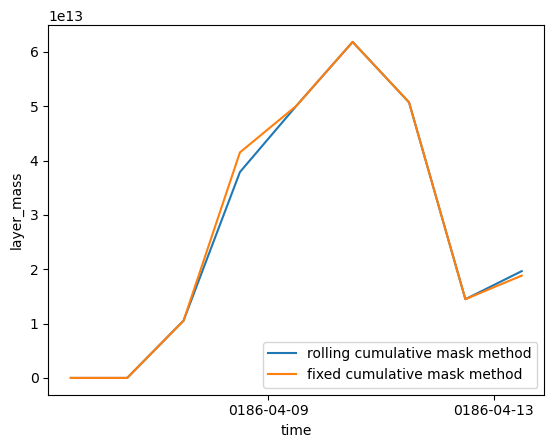

In [448]:
wmt.layer_mass.sel(thetao_l_target=slice(29.0, None)).sum("thetao_l_target").plot(label="rolling cumulative mask method")
wmt_old_cumulative_mask.layer_mass.sel(thetao_l_target=slice(29.0, None)).sum("thetao_l_target").plot(label="fixed cumulative mask method")
plt.legend()